In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('PSP_Jan_Feb_2019.csv')

In [3]:
data['tmsp'] = pd.to_datetime(data['tmsp'])

In [7]:
data = data[data['success'] == 1]
data.shape

(10228, 7)

## Train Test Split

In [54]:
# X_train = data[data['tmsp'] < '2019-02-15']
# X_val = data[(data['tmsp'] >= '2019-02-15') & (data['tmsp'] < '2019-02-22')]
# X_test = data[data['tmsp'] >= '2019-02-22']

In [85]:
from sklearn.model_selection import train_test_split

X = data # Features
y = data['PSP']  # Target variable

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

# Display the shapes of the datasets to verify the split
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (7159, 7), (7159,)
Validation set shape: (2762, 7), (2762,)
Test set shape: (307, 7), (307,)


In [86]:
X_train.PSP.value_counts()

PSP
UK_Card       3599
Simplecard    1363
Moneycard     1270
Goldcard       927
Name: count, dtype: int64

In [87]:
X_train.shape, X_val.shape, X_test.shape

((7159, 7), (2762, 7), (307, 7))

In [88]:
y_train = X_train['PSP']
y_val = X_val['PSP']
y_test = X_test['PSP']

## Feature Engineering

In [90]:
success_rate = X_train.groupby(['country', 'card'])['success'].mean().reset_index()
success_rate.rename(columns={'success': 'country_card_success_rate'}, inplace=True)
X_train = X_train.merge(success_rate, on=['country', 'card'], how='left')

In [91]:
from math import ceil
# Create a new feature 'week_of_month' to extract the week number of the month from the timestamp
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

X_train['week_of_month'] = X_train['tmsp'].apply(week_of_month)

In [92]:
X_train['hour'] = X_train['tmsp'].dt.hour

In [93]:
# Create a new feature 'transaction_hour' to categorize transactions into different time periods of the day
def categorize_hour(hour):
    if 0 <= hour < 6:
        return 'Midnight'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

X_train['transaction_hour'] = X_train['hour'].apply(categorize_hour)

# Create a new feature 'amount_category' to categorize transaction amounts into different ranges
def categorize_amount(amount):
    if amount < 133:
        return 'Low'
    elif 133 <= amount < 201:
        return 'Medium'
    else:
        return 'High'

X_train['amount_category'] = X_train['amount'].apply(categorize_amount)

In [94]:
X_train['weekday'] = X_train['tmsp'].dt.day_name()

In [95]:
country_psp_success_rate = X_train.groupby(['country', 'PSP'])['success'].mean().reset_index()

country_psp_success_rate.rename(columns={'success': 'country_psp_success_rate'}, inplace=True)

X_train = X_train.merge(country_psp_success_rate, on=['country', 'PSP'], how='left')

In [96]:
uk_card_germany_successrate = X_train[(X_train['PSP'] == 'UK_Card') & (X_train['country'] == 'Germany')]['success'].mean()
X_train['uk_card_germany_successrate'] = X_train.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'UK_Card' else 0, axis=1
)

uk_card_autria_successrate = X_train[(X_train['PSP'] == 'UK_Card') & (X_train['country'] == 'Austria')]['success'].mean()
X_train['uk_card_austria_successrate'] = X_train.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Austria' and row['PSP'] == 'UK_Card' else 0, axis=1
)

uk_card_swiz_successrate = X_train[(X_train['PSP'] == 'UK_Card') & (X_train['country'] == 'Switzerland')]['success'].mean()
X_train['uk_card_swiz_successrate'] = X_train.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'UK_Card' else 0, axis=1
)

simplecard_germany_successrate = X_train[(X_train['PSP'] == 'Simplecard') & (X_train['country'] == 'Germany')]['success'].mean()
X_train['simplecard_germany_successrate'] = X_train.apply(
    lambda row: simplecard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Simplecard' else 0, axis=1
)

simplecard_autria_successrate = X_train[(X_train['PSP'] == 'Simplecard') & (X_train['country'] == 'Austria')]['success'].mean()
X_train['simplecard_austria_successrate'] = X_train.apply(
    lambda row: simplecard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Simplecard' else 0, axis=1
)

simplecard_swiz_successrate = X_train[(X_train['PSP'] == 'Simplecard') & (X_train['country'] == 'Switzerland')]['success'].mean()
X_train['simplecard_swiz_successrate'] = data.apply(
    lambda row: simplecard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Simplecard' else 0, axis=1
)

moneycard_germany_successrate = X_train[(X_train['PSP'] == 'Moneycard') & (X_train['country'] == 'Germany')]['success'].mean()
X_train['moneycard_germany_successrate'] = X_train.apply(
    lambda row: moneycard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Moneycard' else 0, axis=1
)

moneycard_autria_successrate = X_train[(X_train['PSP'] == 'Moneycard') & (X_train['country'] == 'Austria')]['success'].mean()
X_train['moneycard_austria_successrate'] = X_train.apply(
    lambda row: moneycard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Moneycard' else 0, axis=1
)

moneycard_swiz_successrate = X_train[(X_train['PSP'] == 'Moneycard') & (X_train['country'] == 'Switzerland')]['success'].mean()
X_train['moneycard_swiz_successrate'] = X_train.apply(
    lambda row: moneycard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Moneycard' else 0, axis=1
)

goldcard_germany_successrate = X_train[(X_train['PSP'] == 'Goldcard') & (X_train['country'] == 'Germany')]['success'].mean()
X_train['goldcard_germany_successrate'] = X_train.apply(
    lambda row: goldcard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Goldcard' else 0, axis=1
)

goldcard_autria_successrate = X_train[(X_train['PSP'] == 'Goldcard') & (X_train['country'] == 'Austria')]['success'].mean()
X_train['goldcard_austria_successrate'] = X_train.apply(
    lambda row: goldcard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Goldcard' else 0, axis=1
)

goldcard_swiz_successrate = X_train[(X_train['PSP'] == 'Goldcard') & (X_train['country'] == 'Switzerland')]['success'].mean()
X_train['goldcard_swiz_successrate'] = X_train.apply(
    lambda row: goldcard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Goldcard' else 0, axis=1
)

## Feature mapping

In [97]:
def add_country_card_success_rate(df):

    for index, row in df.iterrows():

        if row['country'] == 'Germany' and row['card'] == 'Visa':
            df.at[index, 'country_card_success_rate'] = 0.216914
        if row['country'] == 'Germany' and row['card'] == 'Master':
            df.at[index, 'country_card_success_rate'] = 0.195348
        if row['country'] == 'Germany' and row['card'] == 'Diners':
            df.at[index, 'country_card_success_rate'] = 0.226308

        if row['country'] == 'Austria' and row['card'] == 'Visa':
            df.at[index, 'country_card_success_rate'] = 0.204069
        if row['country'] == 'Austria' and row['card'] == 'Master':
            df.at[index, 'country_card_success_rate'] = 0.198462
        if row['country'] == 'Austria' and row['card'] == 'Diners':
            df.at[index, 'country_card_success_rate'] = 0.238686

        if row['country'] == 'Switzerland' and row['card'] == 'Visa':
            df.at[index, 'country_card_success_rate'] = 0.219988
        if row['country'] == 'Switzerland' and row['card'] == 'Master':
            df.at[index, 'country_card_success_rate'] = 0.195551
        if row['country'] == 'Switzerland' and row['card'] == 'Diners':
            df.at[index, 'country_card_success_rate'] = 0.217274
        
    return df

def categorize_amount(df):
    for index, row in df.iterrows():
        if row['amount'] < 133:
            df.at[index, 'amount_category'] = 'Low'
        elif 133 <= row['amount'] < 201:
            df.at[index, 'amount_category'] = 'Medium'
        else:
            df.at[index, 'amount_category'] = 'High'
    return df

def datetime_features(df):
    df['tmsp'] = pd.to_datetime(df['tmsp'])
    df['week_of_month'] = df['tmsp'].apply(week_of_month)
    df['hour'] = df['tmsp'].dt.hour
    df['transaction_hour'] = df['hour'].apply(categorize_hour)
    df['weekday'] = df['tmsp'].dt.day_name()
    return df

def add_country_psp_success_rate(df):

    for index, row in df.iterrows():

        if row['country'] == 'Germany':
            df.at[index, 'uk_card_germany_successrate'] = 0.19908
            df.at[index, 'goldcard_germany_successrate'] = 0.39625
            df.at[index, 'simplecard_germany_successrate'] = 0.166252
            df.at[index, 'moneycard_germany_successrate'] = 0.213703

        if row['country'] == 'Austria':
            df.at[index, 'uk_card_austria_successrate'] = 0.197558
            df.at[index, 'goldcard_austria_successrate'] = 0.424623
            df.at[index, 'simplecard_austria_successrate'] = 0.162322
            df.at[index, 'moneycard_austria_successrate'] = 0.231570

        if row['country'] == 'Switzerland':
            df.at[index, 'uk_card_swiz_successrate'] = 0.193702
            df.at[index, 'goldcard_swiz_successrate'] = 0.425311
            df.at[index, 'simplecard_swiz_successrate'] = 0.154102
            df.at[index, 'moneycard_swiz_successrate'] = 0.232694
        
    return df

In [98]:
x_val = add_country_card_success_rate(X_val)
x_val = categorize_amount(x_val)
x_val = datetime_features(x_val)
x_val = add_country_psp_success_rate(x_val)

x_test = add_country_card_success_rate(X_test)
x_test = categorize_amount(x_test)
x_test = datetime_features(x_test)
x_test = add_country_psp_success_rate(x_test)

In [99]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

categorical_cols = X_train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])

categorical_cols = x_val.select_dtypes(include=['object']).columns
for col in categorical_cols:
    x_val[col] = label_encoder.fit_transform(x_val[col]) 

categorical_cols = x_test.select_dtypes(include=['object']).columns
for col in categorical_cols:
    x_test[col] = label_encoder.fit_transform(x_test[col]) 

In [100]:
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)

In [101]:
X_train.fillna(0, inplace=True)
x_val.fillna(0, inplace=True)
x_test.fillna(0, inplace=True)

In [102]:
X_train.drop(['tmsp','success','country_psp_success_rate', 'PSP'], axis=1, inplace=True)
x_val.drop(['tmsp','success', 'PSP'], axis=1, inplace=True)
x_test.drop(['tmsp','success', 'PSP'], axis=1, inplace=True)

In [103]:
X_train.shape, x_val.shape, x_test.shape

((7159, 22), (2762, 22), (307, 22))

In [104]:
x_val = x_val[X_train.columns]
x_test = x_test[X_train.columns]

## Oversampling

In [105]:
from imblearn.over_sampling import SMOTE

smote_os = SMOTE(random_state = 42)
X_smote, y_smote = smote_os.fit_resample(X_train, y_train_encoded)

In [106]:
X_smote.shape, y_smote.shape

((14396, 22), (14396,))

In [112]:
X_smote.columns

Index(['country', 'amount', '3D_secured', 'card', 'country_card_success_rate',
       'week_of_month', 'hour', 'transaction_hour', 'amount_category',
       'weekday', 'uk_card_germany_successrate', 'uk_card_austria_successrate',
       'uk_card_swiz_successrate', 'simplecard_germany_successrate',
       'simplecard_austria_successrate', 'simplecard_swiz_successrate',
       'moneycard_germany_successrate', 'moneycard_austria_successrate',
       'moneycard_swiz_successrate', 'goldcard_germany_successrate',
       'goldcard_austria_successrate', 'goldcard_swiz_successrate'],
      dtype='object')

## Modelling

c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


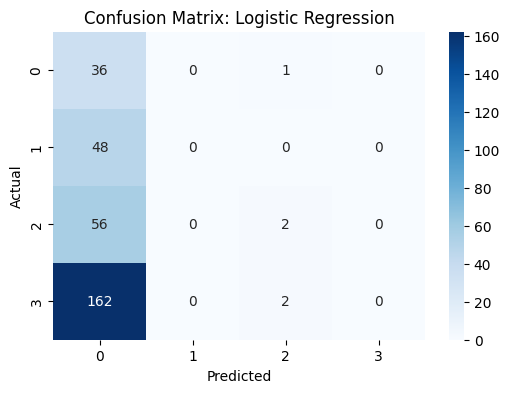

c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


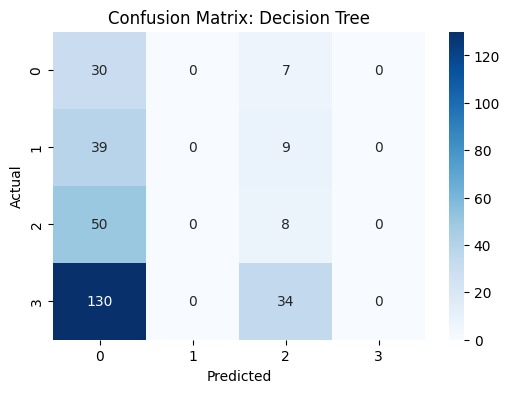

c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


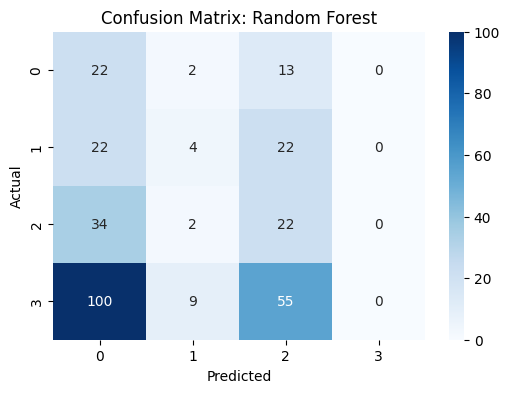

c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


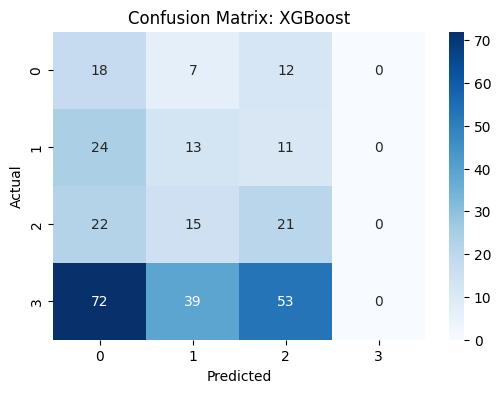

                 Model  Accuracy  F1 Score  Precision    Recall ROC AUC
0  Logistic Regression  0.123779  0.037593   0.089937  0.123779    None
1        Decision Tree  0.123779  0.051343   0.040579  0.123779    None
2        Random Forest  0.156352  0.092806   0.088795  0.156352    None
3              XGBoost  0.169381  0.109593   0.084320  0.169381    None


In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Fit the models and calculate metrics on the test set
results = []
for model_name, model in models.items():
    model.fit(X_smote, y_smote)
    y_pred = model.predict(x_test)
    
    # Check if the model has predict_proba method (for probabilistic classifiers)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(x_test)
        if y_proba.shape[1] == 2:  # Binary classification case: select the probability of the positive class
            y_proba = y_proba[:, 1]
        else:  # If not binary, raise an error or handle appropriately
            y_proba = y_proba.max(axis=1)
    else:
        # If the model doesn't have predict_proba, use decision_function or handle accordingly
        if hasattr(model, "decision_function"):
            y_proba = model.decision_function(x_test)
        else:
            y_proba = y_smote # Use predictions directly if probabilities are unavailable
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    precision = precision_score(y_test_encoded, y_pred, average='weighted')
    recall = recall_score(y_test_encoded, y_pred, average='weighted')
    
    # For ROC AUC, ensure binary classification
    if len(set(y_test_encoded)) == 2:
        roc_auc = roc_auc_score(y_test_encoded, y_proba)
    else:
        roc_auc = None  # Handle multiclass or raise a warning

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc
    })
    
    # Plot ROC-AUC curve if binary classification
    if roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC-AUC curve (for binary classification)
if roc_auc is not None:
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='best')
    plt.show()

# Create a DataFrame with the results
results_df = pd.DataFrame(results)
print(results_df)

## XGBoost Finetuning

In [108]:
pd.Series(y_smote).value_counts()

1    3599
3    3599
2    3599
0    3599
Name: count, dtype: int64

In [109]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model with the training data and validation data
grid_search.fit(X_smote, y_smote)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

y_train_encoded_series = pd.Series(y_smote)
y_val_encoded_series = pd.Series(y_val_encoded)

# Train the final model with the best parameters on the combined training and validation data
final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
final_model.fit(pd.concat([X_smote, x_val]),pd.concat([y_train_encoded_series, y_val_encoded_series]))

# Evaluate the final model on the test set
y_test_pred = final_model.predict(x_test)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Best Cross-Validation Score: 1.0
Test Accuracy: 0.5342019543973942


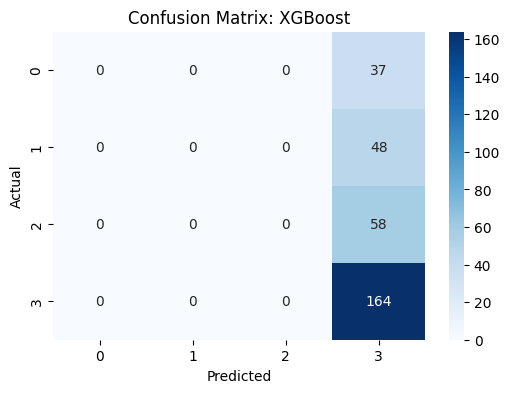

In [110]:
cm = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [111]:
f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')
precision = precision_score(y_test_encoded, y_test_pred, average='weighted')
recall = recall_score(y_test_encoded, y_test_pred, average='weighted')
print(f"F1 Score: {f1}, Precision: {precision}, Recall: {recall}")

F1 Score: 0.37201325062069057, Precision: 0.28537172808199557, Recall: 0.5342019543973942


c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [79]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=10, max_depth=2, random_state=42)
xgb_model.fit(X_train, y_train_encoded)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, ...)

In [80]:
y_test_pred

array([0, 3, 3, ..., 3, 3, 3], dtype=int64)

In [81]:
y_test_pred = final_model.predict(x_test)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.45388127853881277


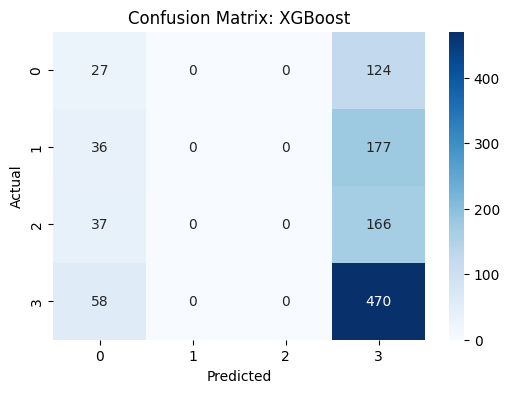

In [82]:
cm = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix: {model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()